<a href="https://colab.research.google.com/github/ikoghoemmanuell/Machine_Learning-Based_Rainfall_Prediction/blob/main/rain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Based Rainfall Prediction

# Installation

In [5]:
# !pip install xgboost
# !pip install -U imbalanced-learn
# !pip install --upgrade scipy
# !pip install threadpoolctl==3.1.0
# !pip install category_encoders
!pip install scikeras

# Importation

In [6]:
# Data handling
import pandas as pd
import numpy as np
import threadpoolctl
# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
import matplotlib.pyplot as plt

# EDA (pandas-profiling, etc. )

# Statistics
from scipy import stats

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from scipy.cluster.hierarchy import dendrogram, linkage

from collections import Counter

# balance data
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, fbeta_score

# Evaluations
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from statistics import stdev
from sklearn.model_selection import KFold

# Other packages
import os, pickle

import warnings
warnings.filterwarnings("ignore")

# Mounting Google Drive
from google.colab import drive  # Import for accessing Google Drive

# Unzipping files
import zipfile  # Import for extracting zip files

# Data Loading

In [7]:
# Mount your Google Drive
drive.mount('/content/drive')

# Get the file path from Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/datasets/rain.zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # Find the CSV files in the zip folder
    file_path = zip_ref.extract('weatherAUS.csv', '/content/')

# Read the csv file from the url
data = pd.read_csv(file_path)

Mounted at /content/drive


Confirming the dataset is same as in the research paper

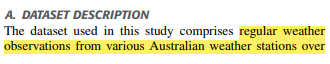

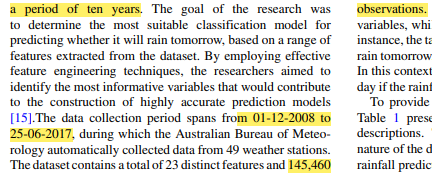

In [11]:
print("from:", data.Date.min(), "to:", data.Date.max())

from: 2007-11-01 to: 2017-06-25


In [12]:
print(len(data))

145460


since its the same length, that was probably a typing error

In [13]:
data.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

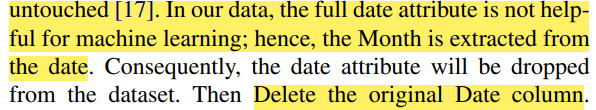

although I do not completely agree, there's nothing wrong with this approach. So let's follow the paper to a T

In [14]:
data['Date'] = pd.to_datetime(data['Date'])

In [15]:
data['Month'] = data['Date'].dt.month

In [16]:
data.drop('Date', inplace=True, axis=1)

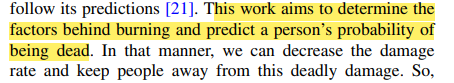

this work was obviously copied from somewhere cuz this project has nothing to do with burning. Researchers do this a lot so I'm not mad at it.

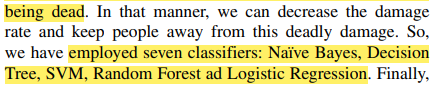

it's good you learn how all of these work so I took the liberty of searching for articles here on medium that simply explain how each model works. Exphasis on "simply", cuz I don't like needless confusion, haha.

decision tree is my favorite, but dont tell the researcher I said that. Our little secret haha.

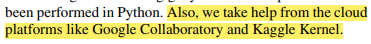

you all know that anything kaggle is a trigger for me, lol. Let's ignore it and use only google colab.

Outliers for each attribute are presented using the boxplot function.

Text(0.5, 1.0, 'Box Plot of Variables')

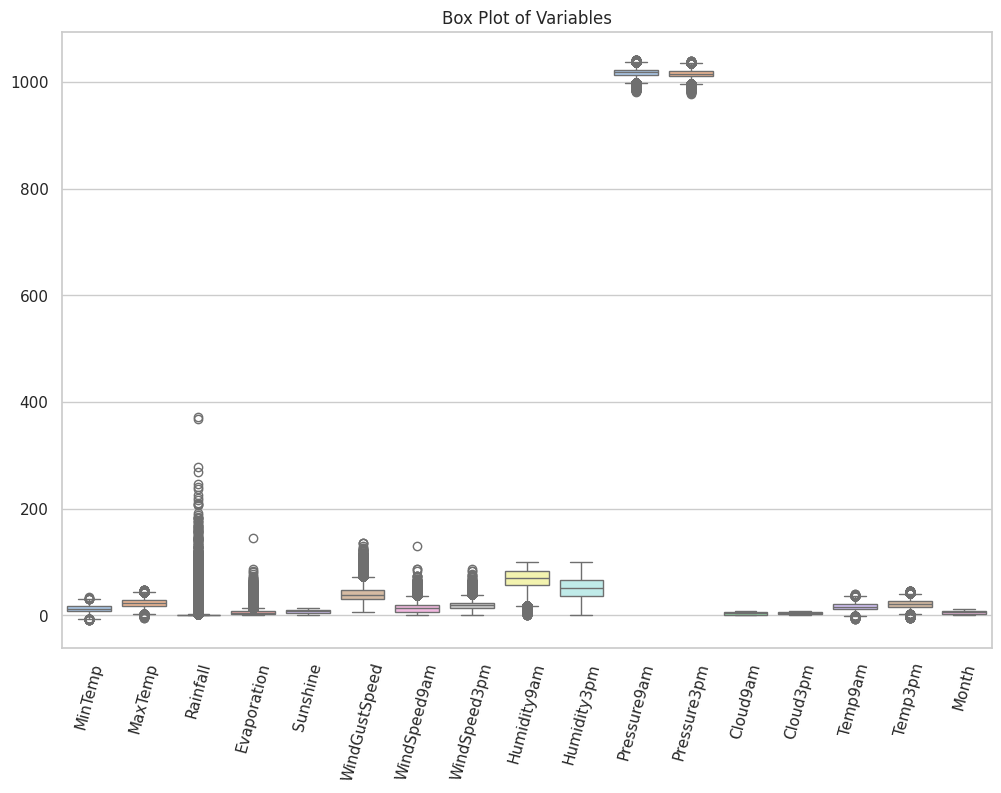

In [17]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

sns.boxplot(data=data, palette="pastel")  # Choose a color palette

# Customize the plot further (adjust as needed)
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.title("Box Plot of Variables")

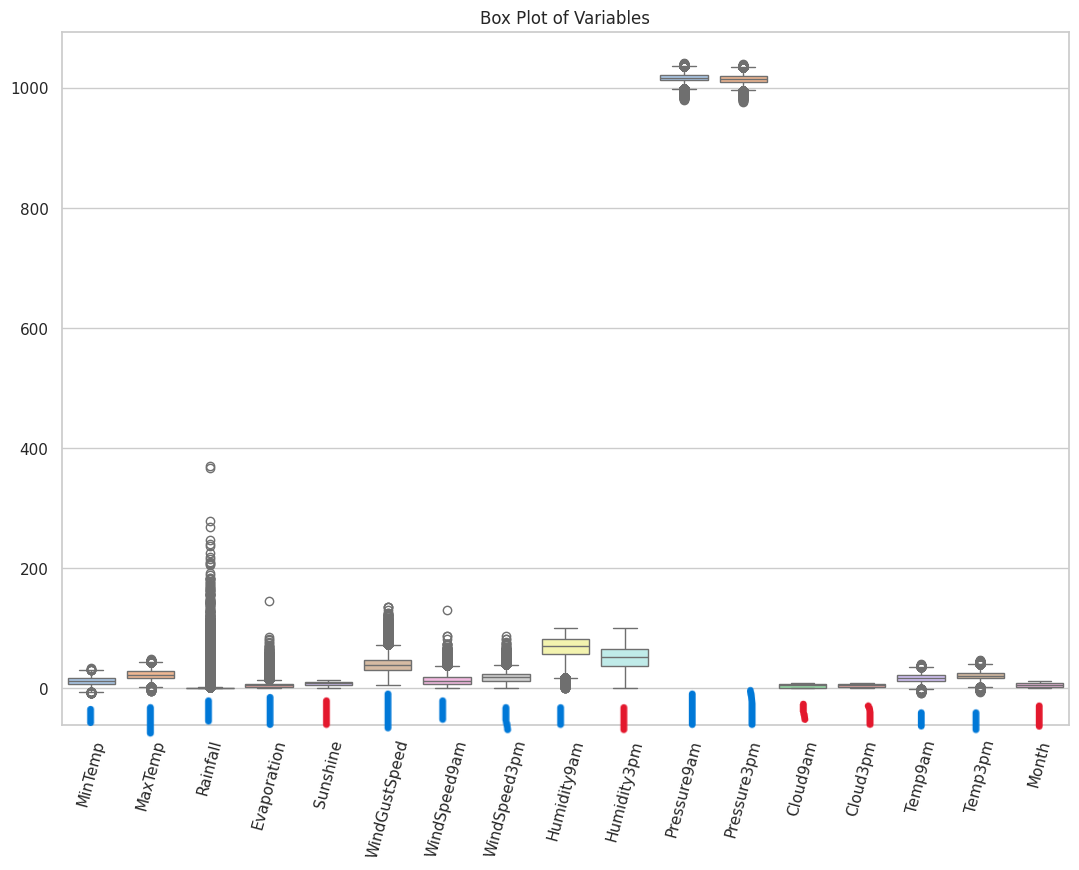

almost all the variables have outliers except those I've marked red do not have outliers

so let us create a list of numeric columns and remove those without outliers so we can focus on the rest

In [18]:
numeric = [col for col in data.columns if data[col].dtype in ['int32', 'int64', 'float64']]
numeric.remove('Sunshine')
numeric.remove('Humidity3pm')
numeric.remove('Cloud9am')
numeric.remove('Cloud3pm')
numeric.remove('Month')

creating histograms to visually assess
whether the distributions exhibit normalcy or skewness.

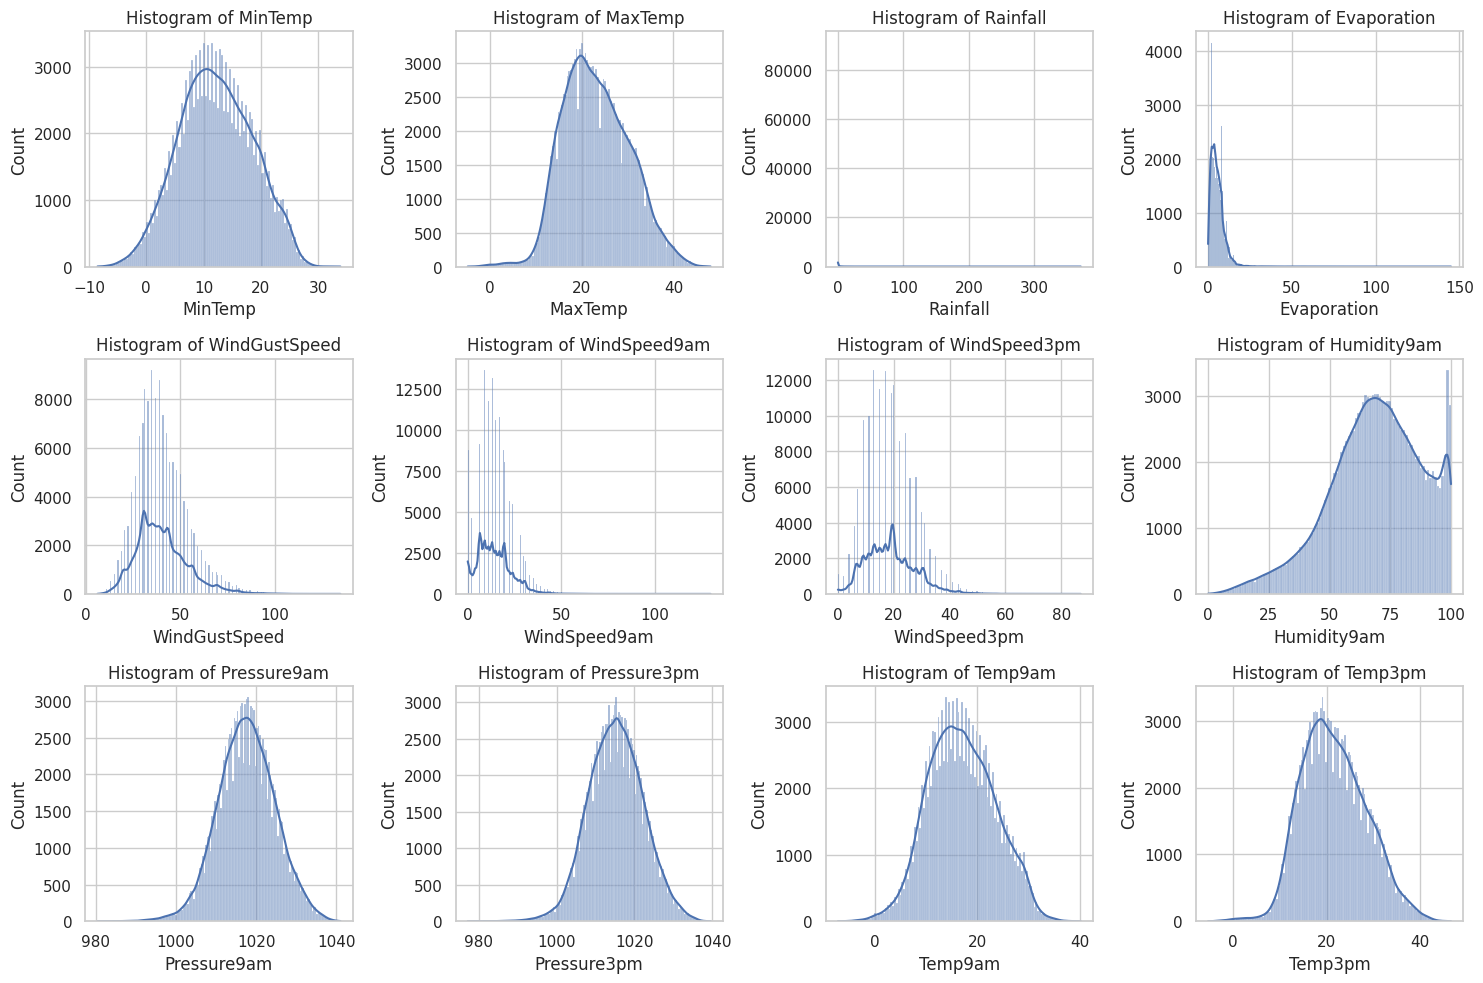

In [19]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(data[numeric].columns) / 4)), ncols=4, figsize=(15, 10))
for i, column in enumerate(data[numeric].columns):
    ax = axes.flatten()[i]
    sns.histplot(data=data, x=column, kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

based on the above plot, the variables with a normal distribution are: MinTemp, MaxTemp, Pressure9am, Pressure3pm, Temp9am and Temp3pm. They all have a bell-shaped curve.

while the rest are skewed

D’Agostino’s K^2 Test

In [20]:
# loop over each numerical column and test for normality
for col in data[numeric]:
    stat, p = stats.normaltest(data[col])
    # print('Statistics=%.5f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'looks Gaussian for this column: {col}')
    else:
        print(f'does not look Gaussian for this column: {col}')

does not look Gaussian for this column: MinTemp
does not look Gaussian for this column: MaxTemp
does not look Gaussian for this column: Rainfall
does not look Gaussian for this column: Evaporation
does not look Gaussian for this column: WindGustSpeed
does not look Gaussian for this column: WindSpeed9am
does not look Gaussian for this column: WindSpeed3pm
does not look Gaussian for this column: Humidity9am
does not look Gaussian for this column: Pressure9am
does not look Gaussian for this column: Pressure3pm
does not look Gaussian for this column: Temp9am
does not look Gaussian for this column: Temp3pm


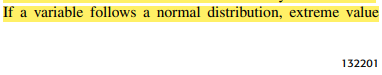

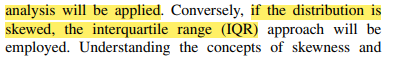

Extreme value analysis can be used for datasets that have a normal or gaussian distribution. For those variables with a bell shaped curve, its obvious that most values are close to the mean.

Looking at minTemp for example, most minimum temperature is about 10 degrees. Meaning that the outliers or extreme values are on both ends of the curve, very far away from the mean. Very far from 10.

The z-score is a method that shows you how many standard deviations a data point is from the mean. A very high or low z-score shows that a value is far away from the mean, meaning its an outlier (usually above 3 or below -3).

Z-score is also suitable for small to meduim sized datasets which is what we have here. So let's go ahead and use this method.

In [21]:
variables_of_interest = ['MinTemp', 'MaxTemp', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

# Calculate the z-scores for the variables of interest
z_scores = np.abs((data[variables_of_interest] - data[variables_of_interest].mean()) / data[variables_of_interest].std())

# Set a threshold for detecting outliers (commonly, a z-score > 3 indicates an outlier)
threshold = 3
outliers = z_scores > threshold

# Keep only the rows where no outliers exist in any of the specified variables
data_without_outliers = data[~outliers.any(axis=1)]

In [22]:
len(data_without_outliers)

144304

In [23]:
# Remove the values in variables_of_interest from the numeric list
variables_with_skewed_distribution = [var for var in numeric if var not in variables_of_interest]
variables_with_skewed_distribution

['Rainfall',
 'Evaporation',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am']

for these variables, the outliers distort the mean. So we cannot rely on the mean as a refrence to detect outliers. Let's use the Interquartile Range (IQR) method. Here is an example of how it works:

If we have a distribution of heights where the outliers distort the mean, making it skewed to one end, then using the IQR method.

If most people are between 5ft to 6ft tall, then my girlfriend who's 6'3 is an anomaly. (Don't tell her I said that).

the Interquartile Range (IQR) focuses on the middle 50% of the data, instead of comparing to a single mean value.

In [24]:
# # Loop through each variable in variables_with_skewed_distribution
# for col in variables_with_skewed_distribution:
#     # Calculate the 1st and 3rd quartiles (Q1 and Q3)
#     Q1 = data_without_outliers[col].quantile(0.25)
#     Q3 = data_without_outliers[col].quantile(0.75)

#     # Calculate the Interquartile Range (IQR)
#     IQR = Q3 - Q1

#     # Determine the lower and upper bounds for outliers
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Filter the dataset, keeping only the rows where the variable values are within the bounds
#     data_without_outliers = data_without_outliers[(data_without_outliers[col] >= lower_bound) & (data_without_outliers[col] <= upper_bound)]

In [25]:
len(data_without_outliers)

144304

In [26]:
data = data_without_outliers

In [27]:
data.duplicated().sum()

177

let's have a closer look at the duplicates

In [28]:
dup = data.loc[data.duplicated(),:]
dup.head(22)

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
985           Albury      NaN      NaN       NaN          NaN       NaN   
2032          Albury      NaN      NaN       NaN          NaN       NaN   
3526   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5460   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5461   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5843   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5844   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5845   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5846   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5847   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5848   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5849   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5850   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5851   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5852   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5853   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5854   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5855   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
5856   BadgerysCreek      NaN      NaN       NaN          NaN       NaN   
10922   CoffsHarbour      NaN      NaN       NaN          NaN       NaN   
10923   CoffsHarbour      NaN      NaN       NaN          NaN       NaN   
10924   CoffsHarbour      NaN      NaN       NaN          NaN       NaN   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
985           NaN            NaN        NaN        NaN  ...          NaN   
2032          NaN            NaN        NaN        NaN  ...          NaN   
3526          NaN            NaN        NaN        NaN  ...          NaN   
5460          NaN            NaN        NaN        NaN  ...          NaN   
5461          NaN            NaN        NaN        NaN  ...          NaN   
5843          NaN            NaN        NaN        NaN  ...          NaN   
5844          NaN            NaN        NaN        NaN  ...          NaN   
5845          NaN            NaN        NaN        NaN  ...          NaN   
5846          NaN            NaN        NaN        NaN  ...          NaN   
5847          NaN            NaN        NaN        NaN  ...          NaN   
5848          NaN            NaN        NaN        NaN  ...          NaN   
5849          NaN            NaN        NaN        NaN  ...          NaN   
5850          NaN            NaN        NaN        NaN  ...          NaN   
5851          NaN            NaN        NaN        NaN  ...          NaN   
5852          NaN            NaN        NaN        NaN  ...          NaN   
5853          NaN            NaN        NaN        NaN  ...          NaN   
5854          NaN            NaN        NaN        NaN  ...          NaN   
5855          NaN            NaN        NaN        NaN  ...          NaN   
5856          NaN            NaN        NaN        NaN  ...          NaN   
10922         NaN            NaN        NaN        NaN  ...          NaN   
10923         NaN            NaN        NaN        NaN  ...          NaN   
10924         NaN            NaN        NaN        NaN  ...          NaN   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
985            NaN          NaN       NaN       NaN      NaN      NaN   
2032           NaN          NaN       NaN       NaN      NaN      NaN   
3526           NaN          NaN       NaN       NaN      NaN      NaN   
5460           NaN          NaN       NaN       NaN      NaN      NaN   
5461           NaN          NaN       NaN       NaN      NaN      NaN   
5843           NaN          NaN       NaN       NaN      NaN      NaN   
5844           NaN        

In [29]:
data.drop_duplicates(inplace=True)

In [30]:
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64', 'int32']]
numeric_btw_0_1 = [col for col in data[numeric] if data[col].between(0, 1).all()]
numeric_btw_0_1

[]

they didn't choose between IQR and quartile transformation, so I picked quartile since it simply worked better

the code for IQR is commented in a code block above in case you would like to try it yourself

also that part of doing quartile transformation for only numeric variables between 0 and 1 is clearly made up cuz from the above code you can see that no variable like that is in our dataset

this misdirection is probably as a result of the researchers paraphrasing someone else's work

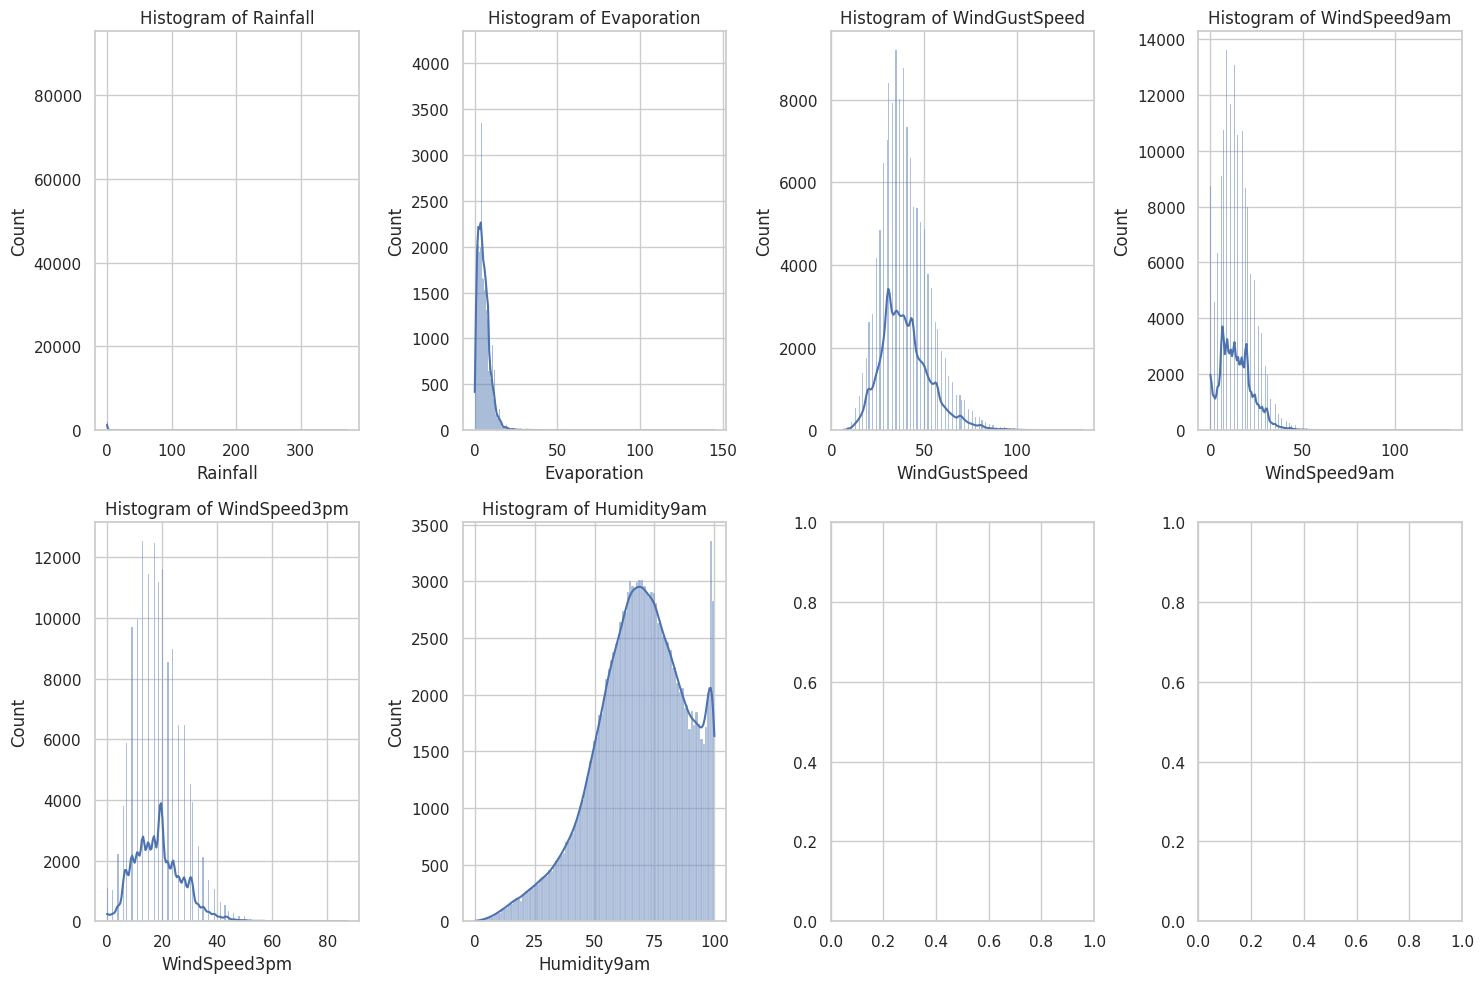

In [31]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(data[variables_with_skewed_distribution].columns) / 4)), ncols=4, figsize=(15, 10))
for i, column in enumerate(data[variables_with_skewed_distribution].columns):
    ax = axes.flatten()[i]
    sns.histplot(data=data, x=column, kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

In [32]:
# Quantile Transformation
quantile_transformer = QuantileTransformer(output_distribution='normal')

for col in variables_with_skewed_distribution:
  data[col] = quantile_transformer.fit_transform(data[[col]].values)

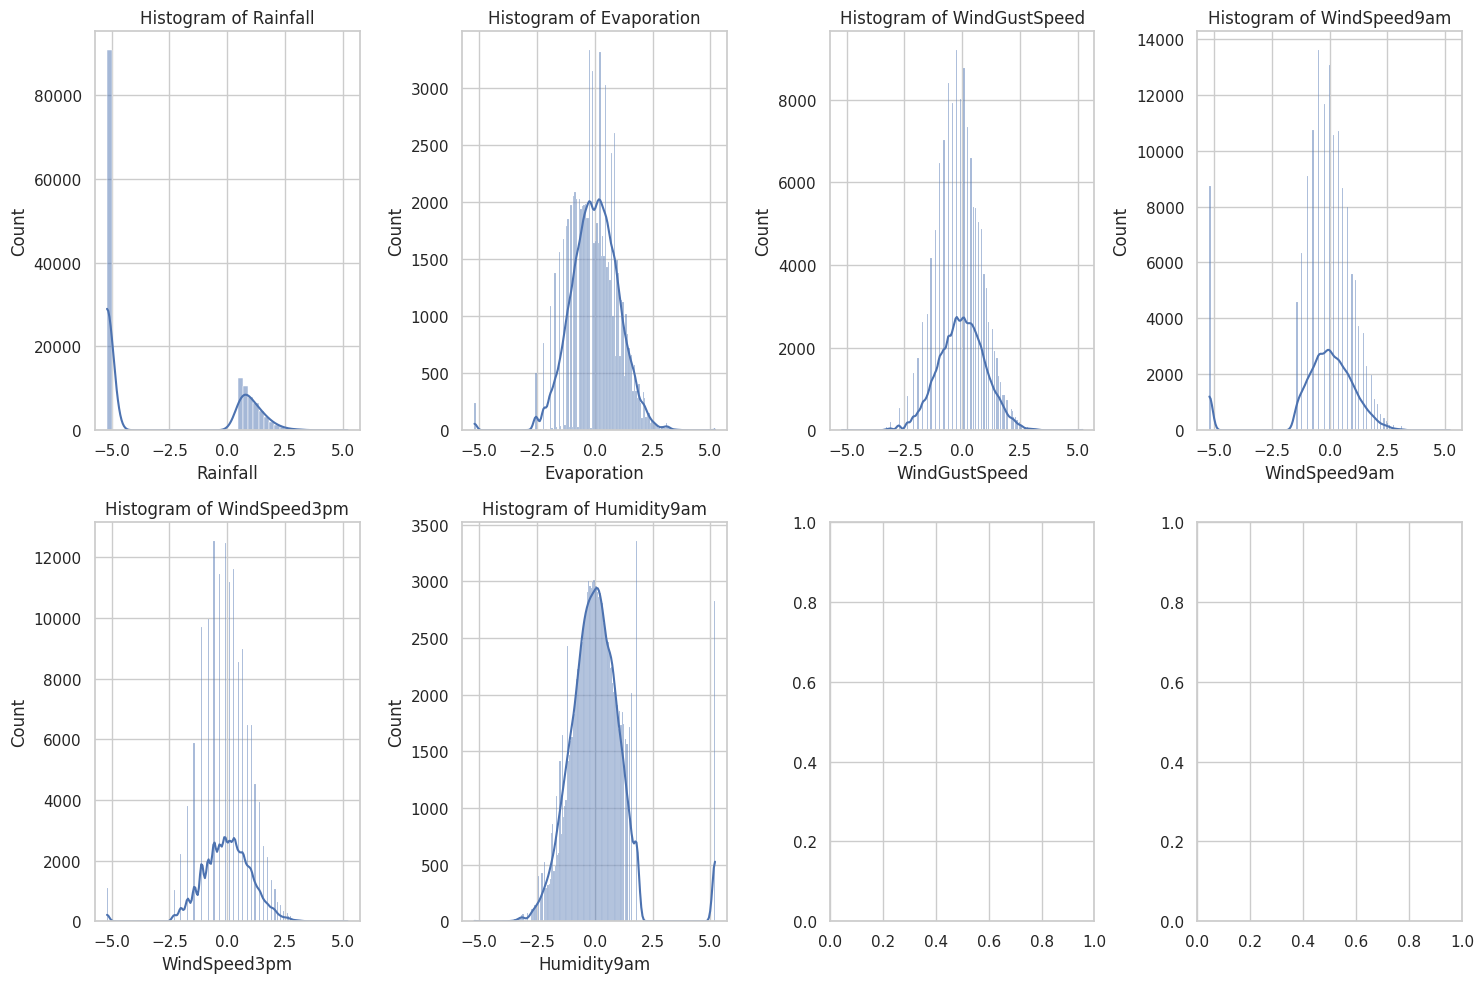

In [33]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(data[variables_with_skewed_distribution].columns) / 4)), ncols=4, figsize=(15, 10))
for i, column in enumerate(data[variables_with_skewed_distribution].columns):
    ax = axes.flatten()[i]
    sns.histplot(data=data, x=column, kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

# Exploratory Data Analysis

In [34]:
df = data

descriptive statistics

In [35]:
df.describe()

MinTemp        MaxTemp       Rainfall   Evaporation      Sunshine  \
count  142832.00000  143050.000000  141042.000000  82145.000000  75133.000000   
mean       12.22700      23.278153      -2.958833      0.004289      7.621413   
std         6.35617       7.007305       3.023233      1.020051      3.782615   
min        -7.00000       1.900000      -5.199338     -5.199338      0.000000   
25%         7.60000      18.000000      -5.199338     -0.673702      4.900000   
50%        12.00000      22.700000      -5.199338      0.037646      8.500000   
75%        16.90000      28.200000       0.689529      0.695908     10.600000   
max        31.00000      44.500000       5.199338      5.199338     14.500000   

       WindGustSpeed   WindSpeed9am   WindSpeed3pm    Humidity9am  \
count  134113.000000  142575.000000  141274.000000  141719.000000   
mean       -0.004008      -0.211339      -0.017759       0.049632   
std         1.003894       1.534269       1.070058       1.189687   
min        -5.199338      -5.199338      -5.199338      -5.199338   
25%        -0.601439      -0.718462      -0.574595      -0.665852   
50%         0.067799      -0.032625       0.096753       0.012546   
75%         0.707140       0.579039       0.676854       0.683178   
max         5.199338       5.199338       5.199338       5.199338   

         Humidity3pm    Pressure9am    Pressure3pm      Cloud9am  \
count  139846.000000  129599.000000  129635.000000  89075.000000   
mean       51.437095    1017.753210    1015.355429      4.442200   
std        20.686773       6.923143       6.865870      2.886949   
min         0.000000     996.400000     994.200000      0.000000   
25%        37.000000    1013.000000    1010.500000      1.000000   
50%        52.000000    1017.700000    1015.300000      5.000000   
75%        66.000000    1022.400000    1020.000000      7.000000   
max       100.000000    1038.900000    1036.300000      9.000000   

           Cloud3pm        Temp9am        Temp3pm          Month  
count  85620.000000  142602.000000  140740.000000  144127.000000  
mean       4.504391      17.027793      21.738574       6.397282  
std        2.720901       6.421852       6.828058       3.429690  
min        0.000000      -2.400000       0.900000       1.000000  
25%        2.000000      12.300000      16.700000       3.000000  
50%        5.000000      16.700000      21.200000       6.000000  
75%        7.000000      21.600000      26.400000       9.000000  
max        9.000000      36.400000      42.400000      12.000000

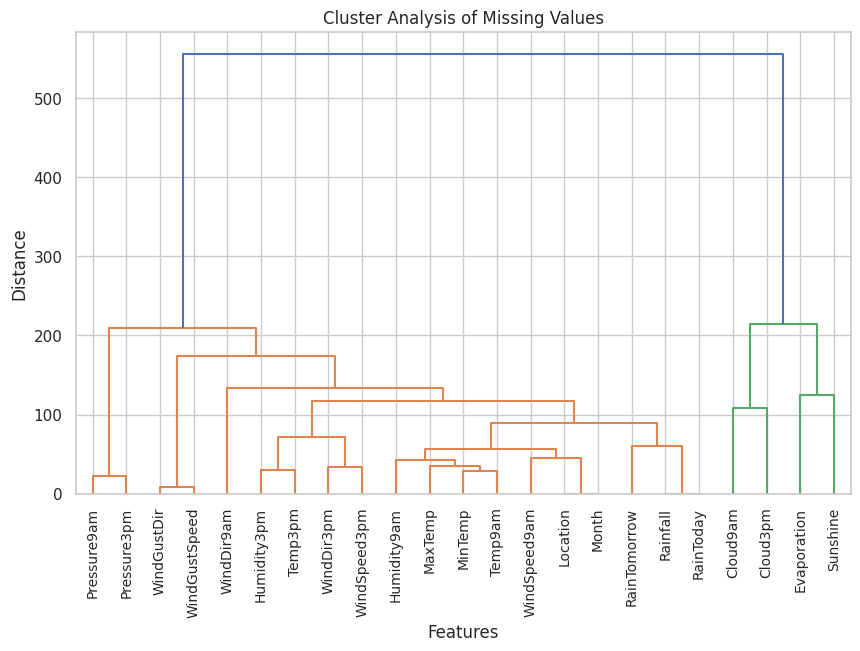

In [36]:
# Convert the missing values into a binary matrix (0: non-missing, 1: missing)
missing_matrix = df.isnull().astype(int).T

# Perform hierarchical clustering using 'ward' method on binary matrix
Z = linkage(missing_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df.columns, leaf_rotation=90)
plt.title('Cluster Analysis of Missing Values')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.show()

The dendogram groups features together in two clusters. The variables in one cluster have similar pattern in how the missing data occurs in the dataset. The closer

The distance of the line represents how much missing values are present. Variables like rainfall and month for example have no missing values.

Later on when we will do feature selection, this diagram will help us select the features that have less missing values, and it will also help us select the variables that have similar patterns of missing values.

variables like "Rain Tomorrow," "Rain Today," "Rainfall," "Date," and "Location," have zero missing values, which is why they are grouped together near the bottom of the dendrogram with shorter branches.

variables like "Humidity 9 am," "Wind Speed 9 am," "Temperature 9 am," "Minimum Temperature," "Maximum Temperature," "Rainfall," "Date," "Rain Tomorrow," and "Rain Today" form a coherent group with minimal missing data. This shows that they have more complete information.

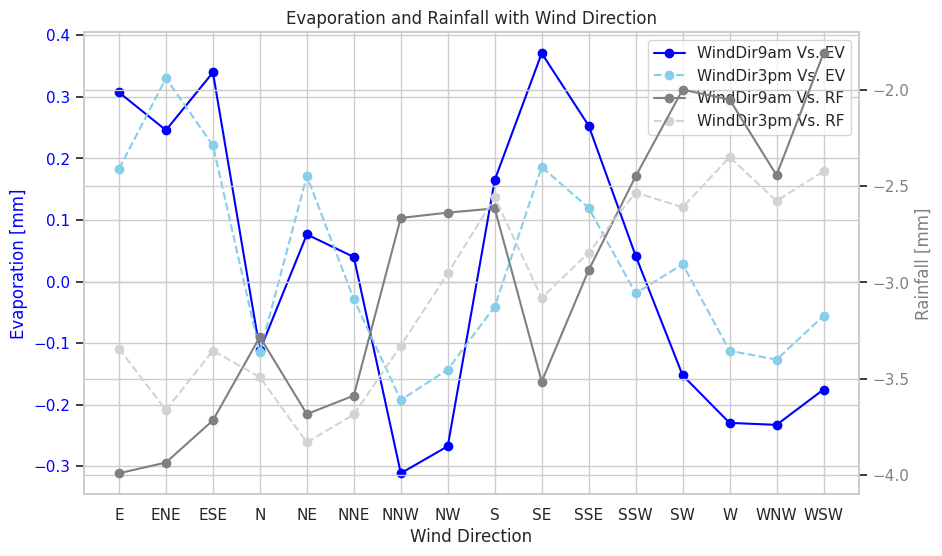

In [37]:
# Drop rows where `Evaporation`, `Rainfall`, `WindDir9am`, or `WindDir3pm` are NaN
df_cleaned = df.dropna(subset=['Evaporation', 'Rainfall', 'WindDir9am', 'WindDir3pm'])

# Group by `WindDir9am` and `WindDir3pm` to get the average Evaporation and Rainfall
# Calculate the mean Evaporation and Rainfall by wind direction
wind_9am_data = df_cleaned.groupby('WindDir9am').agg({
    'Evaporation': 'mean',
    'Rainfall': 'mean'
}).rename(columns={'Evaporation': 'WindDir9am_Evaporation', 'Rainfall': 'WindDir9am_Rainfall'})

wind_3pm_data = df_cleaned.groupby('WindDir3pm').agg({
    'Evaporation': 'mean',
    'Rainfall': 'mean'
}).rename(columns={'Evaporation': 'WindDir3pm_Evaporation', 'Rainfall': 'WindDir3pm_Rainfall'})

# Merge the dataframes on wind directions, fill missing values with NaN if needed
plot_data = pd.concat([wind_9am_data, wind_3pm_data], axis=1)

# Set up the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot WindDir9am vs Evaporation
ax1.plot(plot_data.index, plot_data['WindDir9am_Evaporation'], marker='o', color='blue', linestyle='-', label='WindDir9am Vs. EV')
# Plot WindDir3pm vs Evaporation
ax1.plot(plot_data.index, plot_data['WindDir3pm_Evaporation'], marker='o', color='skyblue', linestyle='--', label='WindDir3pm Vs. EV')
ax1.set_xlabel('Wind Direction')
ax1.set_ylabel('Evaporation [mm]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for Rainfall
ax2 = ax1.twinx()
ax2.plot(plot_data.index, plot_data['WindDir9am_Rainfall'], marker='o', color='gray', linestyle='-', label='WindDir9am Vs. RF')
ax2.plot(plot_data.index, plot_data['WindDir3pm_Rainfall'], marker='o', color='lightgray', linestyle='--', label='WindDir3pm Vs. RF')
ax2.set_ylabel('Rainfall [mm]', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Set the title
plt.title('Evaporation and Rainfall with Wind Direction')
plt.xticks(rotation=45)
plt.show()

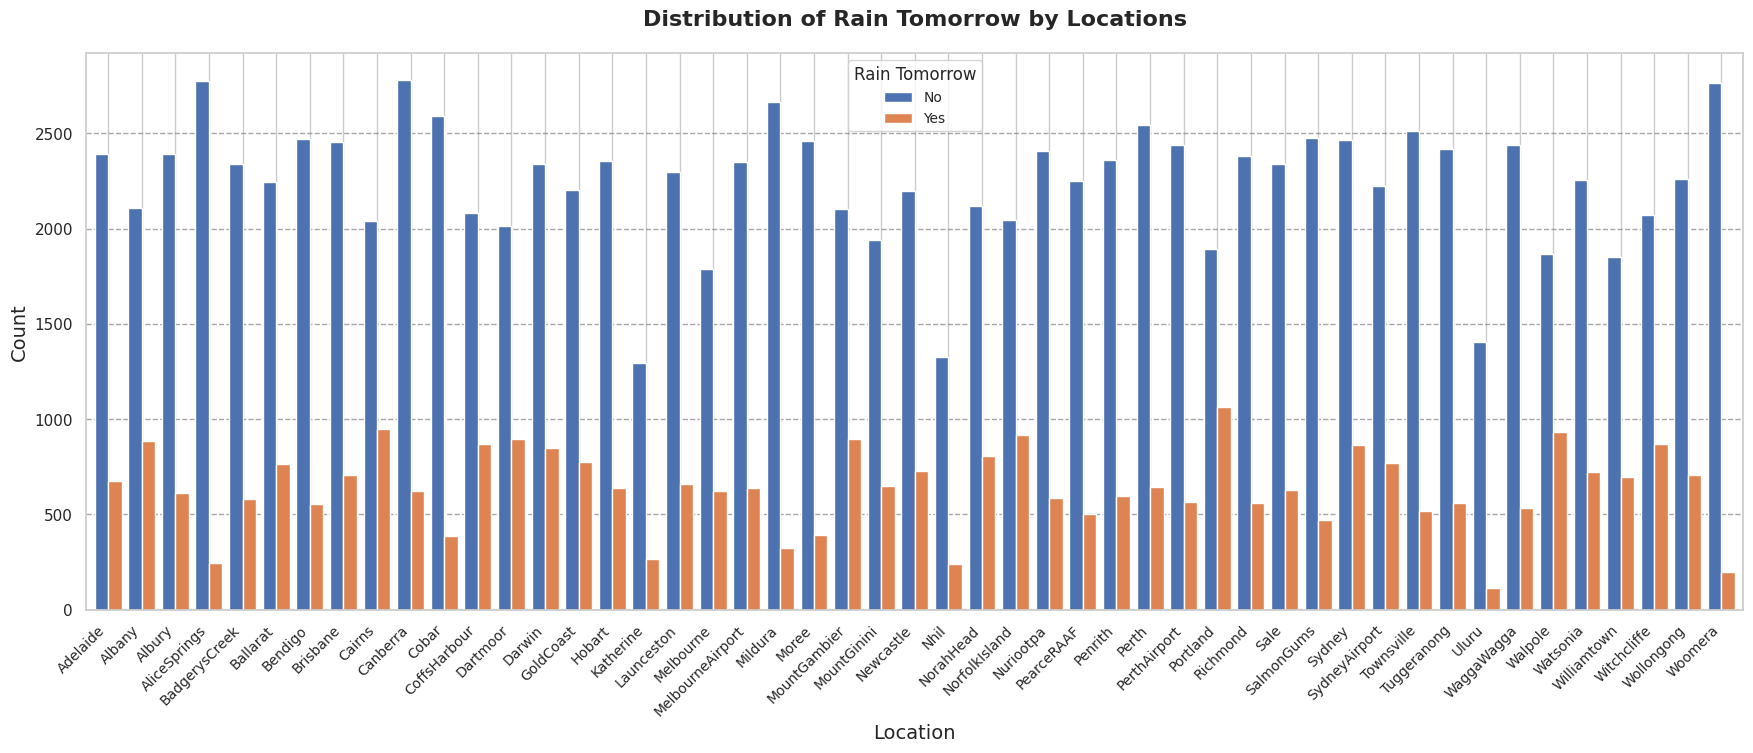

In [38]:
# Set Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Assuming df is already loaded and cleaned (NaN handling, etc.)
df_cleaned = df.dropna(subset=['RainTomorrow', 'Location'])

# Count occurrences of 'Yes' and 'No' in RainTomorrow for each Location
rain_counts = df_cleaned.groupby(['Location', 'RainTomorrow']).size().unstack()

# Plotting
fig, ax = plt.subplots(figsize=(18, 8))  # Larger figure size for better readability

# Define custom colors for "No" and "Yes"
colors = ["#4c72b0", "#dd8452"]  # Soft blue for "No" and warm orange for "Yes"
rain_counts.plot(kind='bar', stacked=False, color=colors, ax=ax, width=0.8)

# Add title and labels with improved font sizes
ax.set_title('Distribution of Rain Tomorrow by Locations', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Location', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Customize x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Add a legend with a clearer title
ax.legend(title='Rain Tomorrow', title_fontsize=12, fontsize=10)

# Add gridlines to the y-axis for easier interpretation
ax.yaxis.grid(True, linestyle='--', color='gray', alpha=0.7)

# Tighten layout and add padding
plt.tight_layout(pad=2)

# Show plot
plt.show()

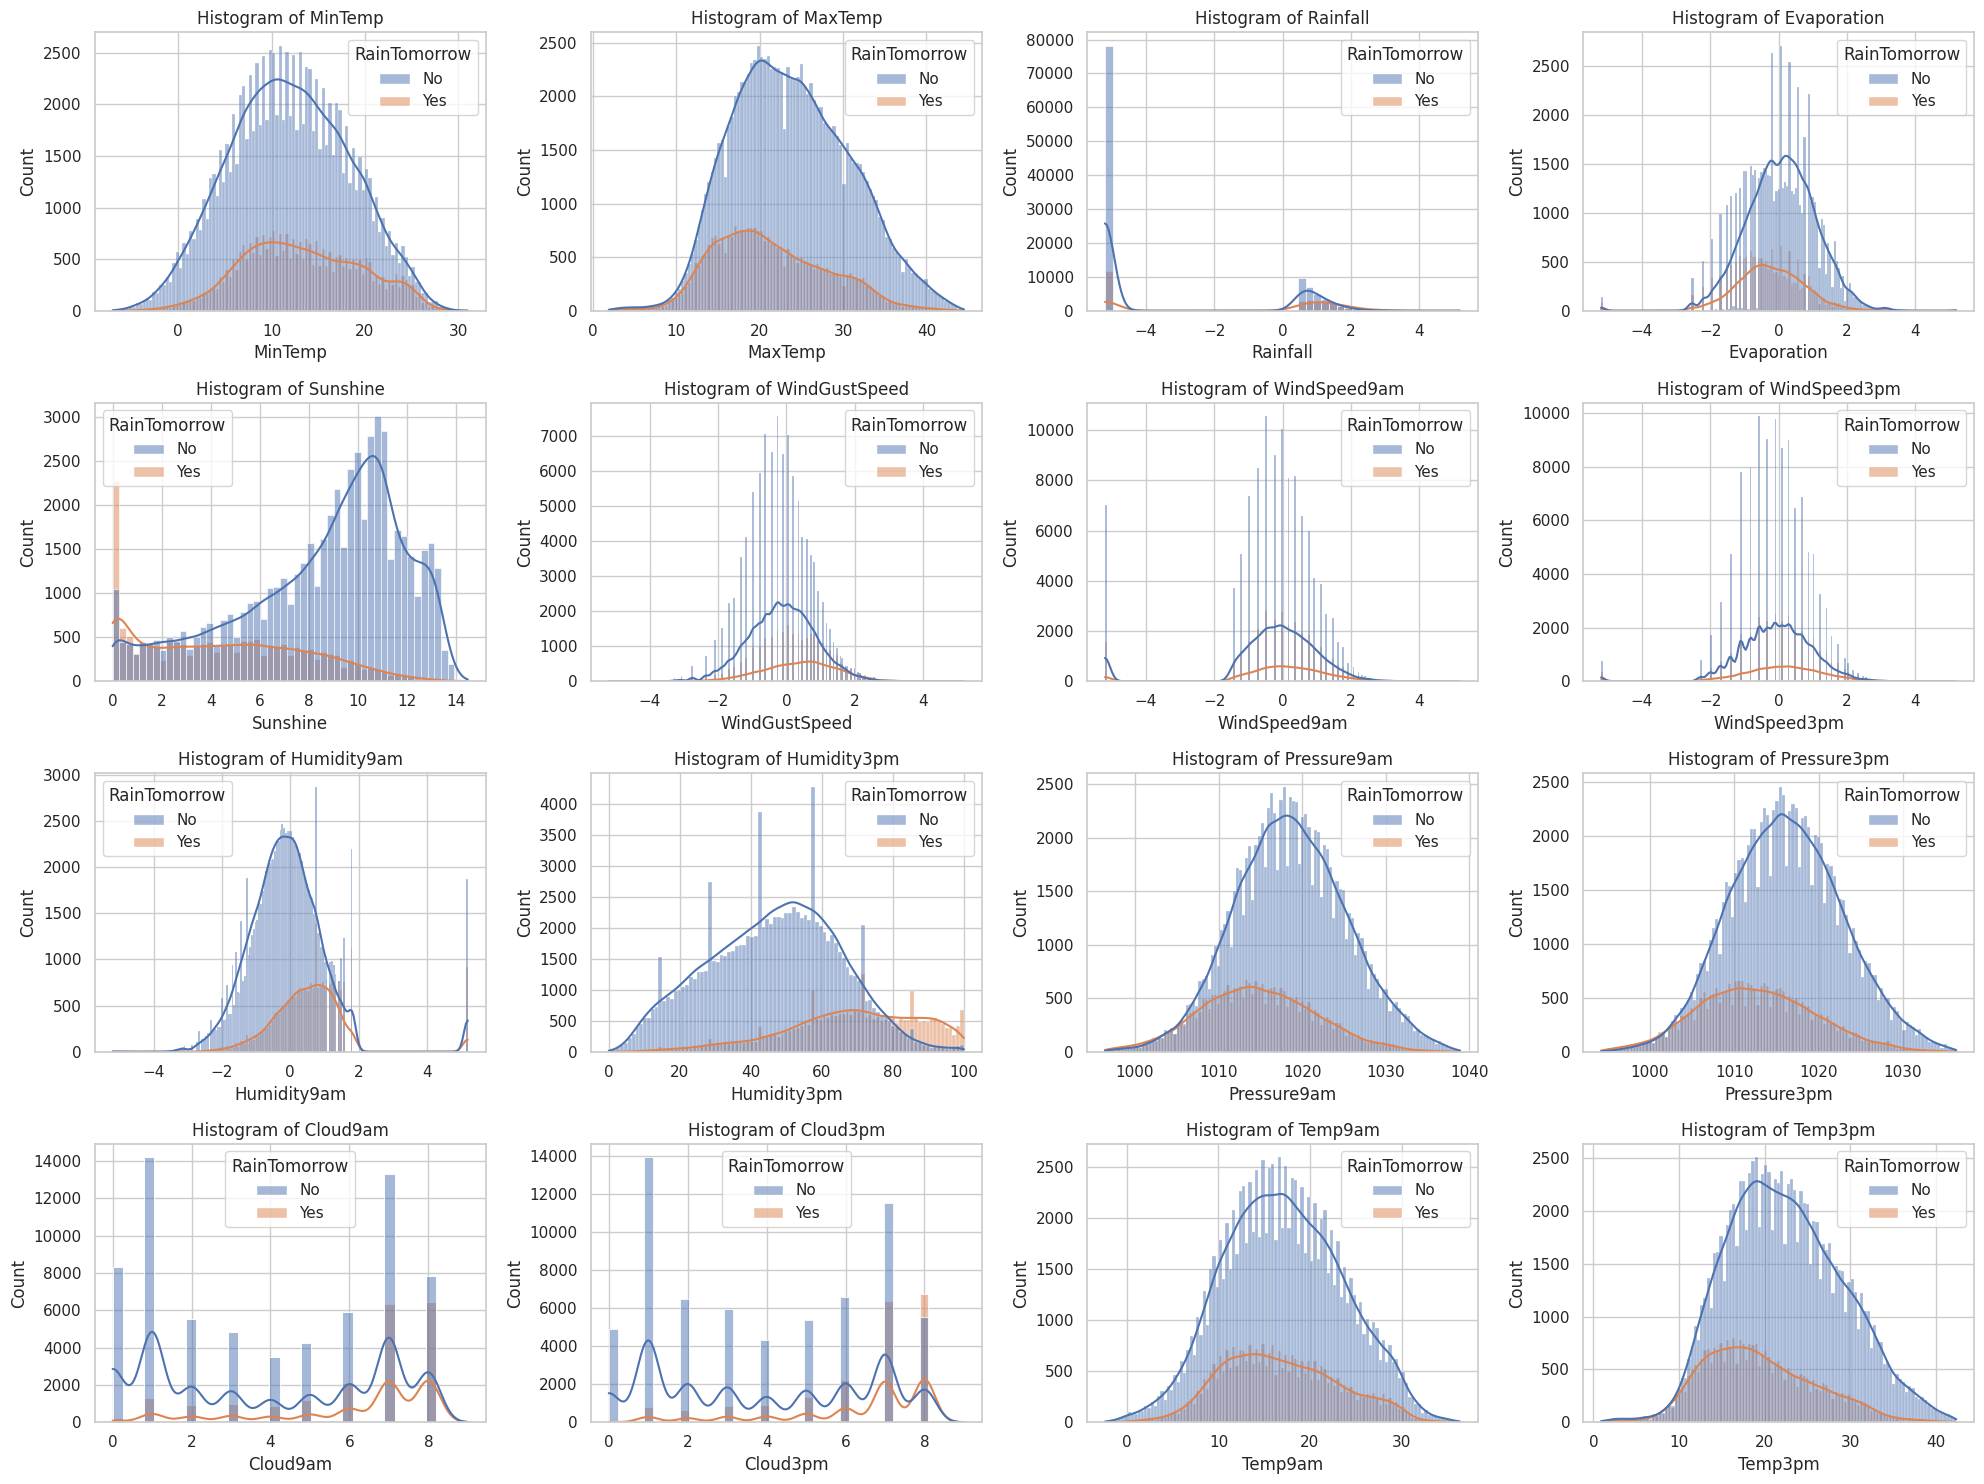

In [39]:
numeric_columns = list(df.select_dtypes(include=['float', 'int']).columns)
numeric_columns.remove('Month')

# Calculate the grid size
n_cols = 4
n_rows = int(np.ceil(len(numeric_columns) / n_cols))

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to easily index axes

# Plot each histogram
for i, column in enumerate(numeric_columns):
    sns.histplot(data=df, x=column, hue='RainTomorrow', alpha=0.5, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Hide any empty subplots (in case number of columns doesn't divide evenly)
for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

there is no rain once the count reaches 1000 for most of the numeric variables

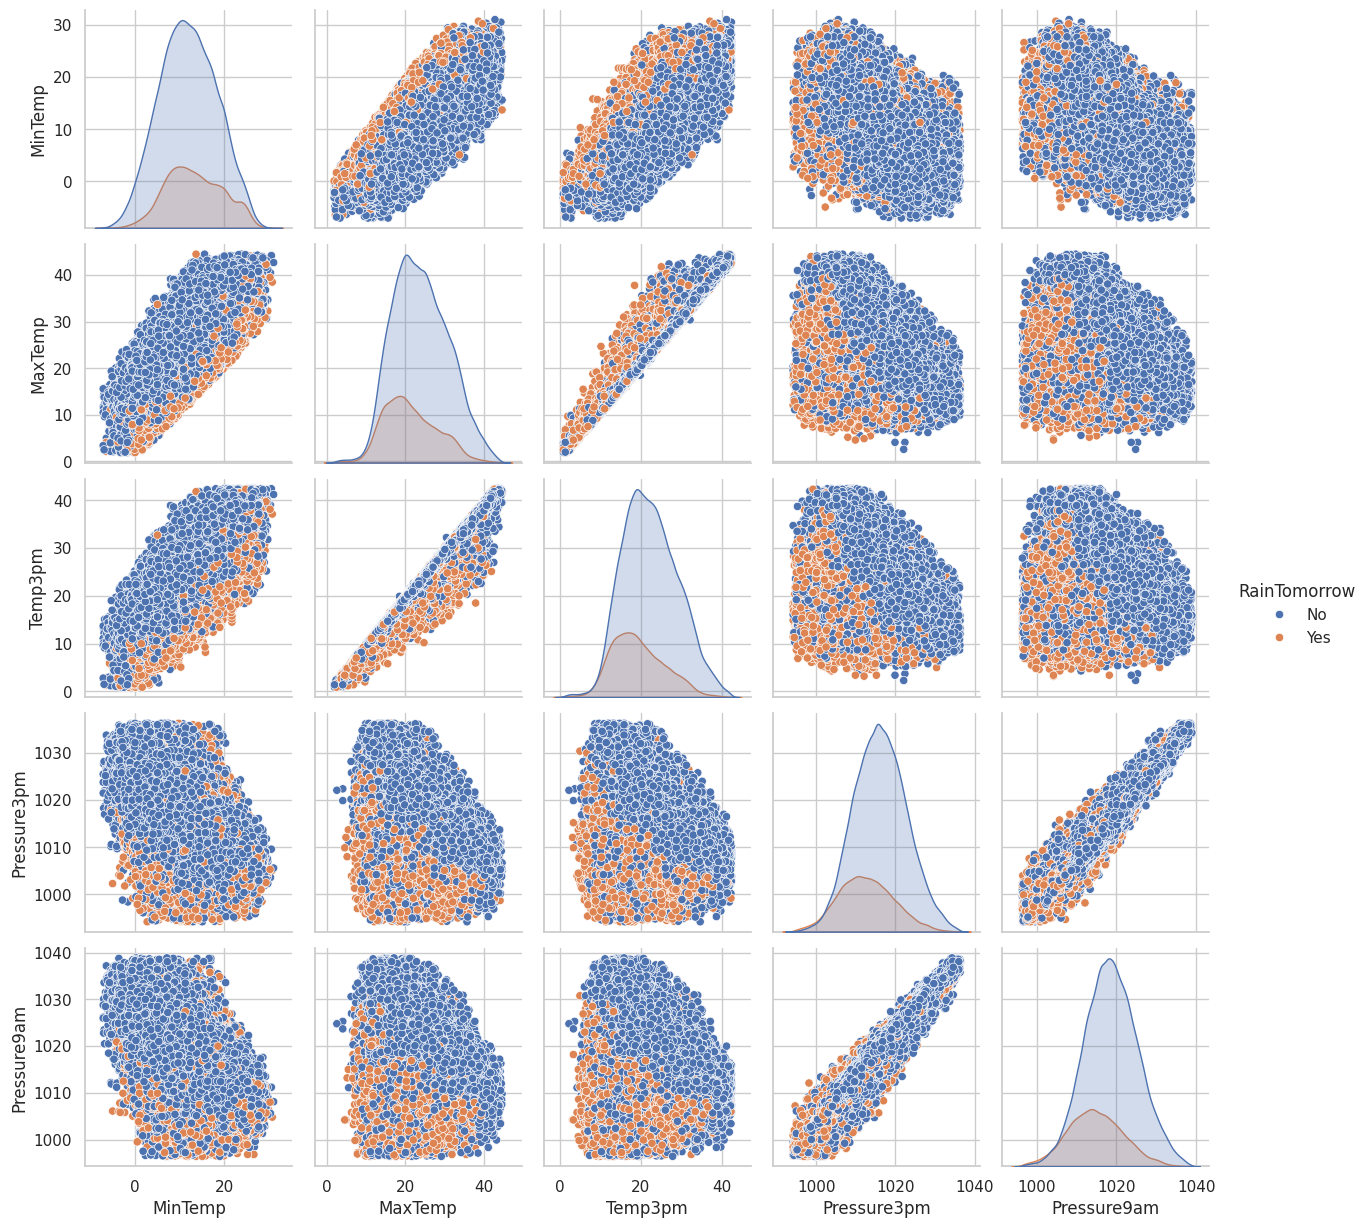

In [40]:
sns.pairplot(df,vars = ['MinTemp', 'MaxTemp', 'Temp3pm', 'Pressure3pm', 'Pressure9am'], hue="RainTomorrow")

MaxTemp and Temp3pm have a strong positive correlation. Same goes for Pressure3pm and Pressure9am.

The screenshot below shows what the researchers had to say about this. I have highlighted it in yellow for your reading pleasure.

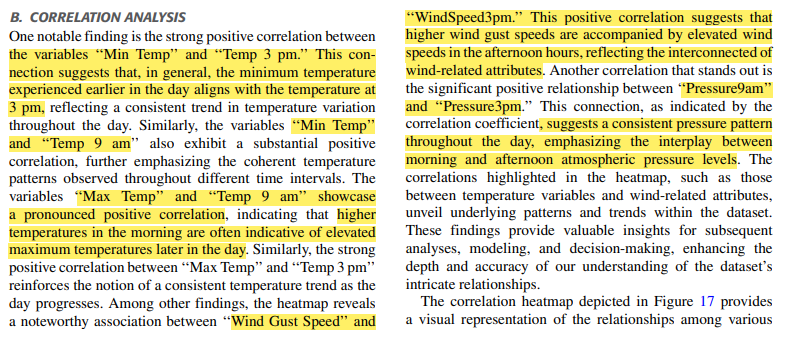

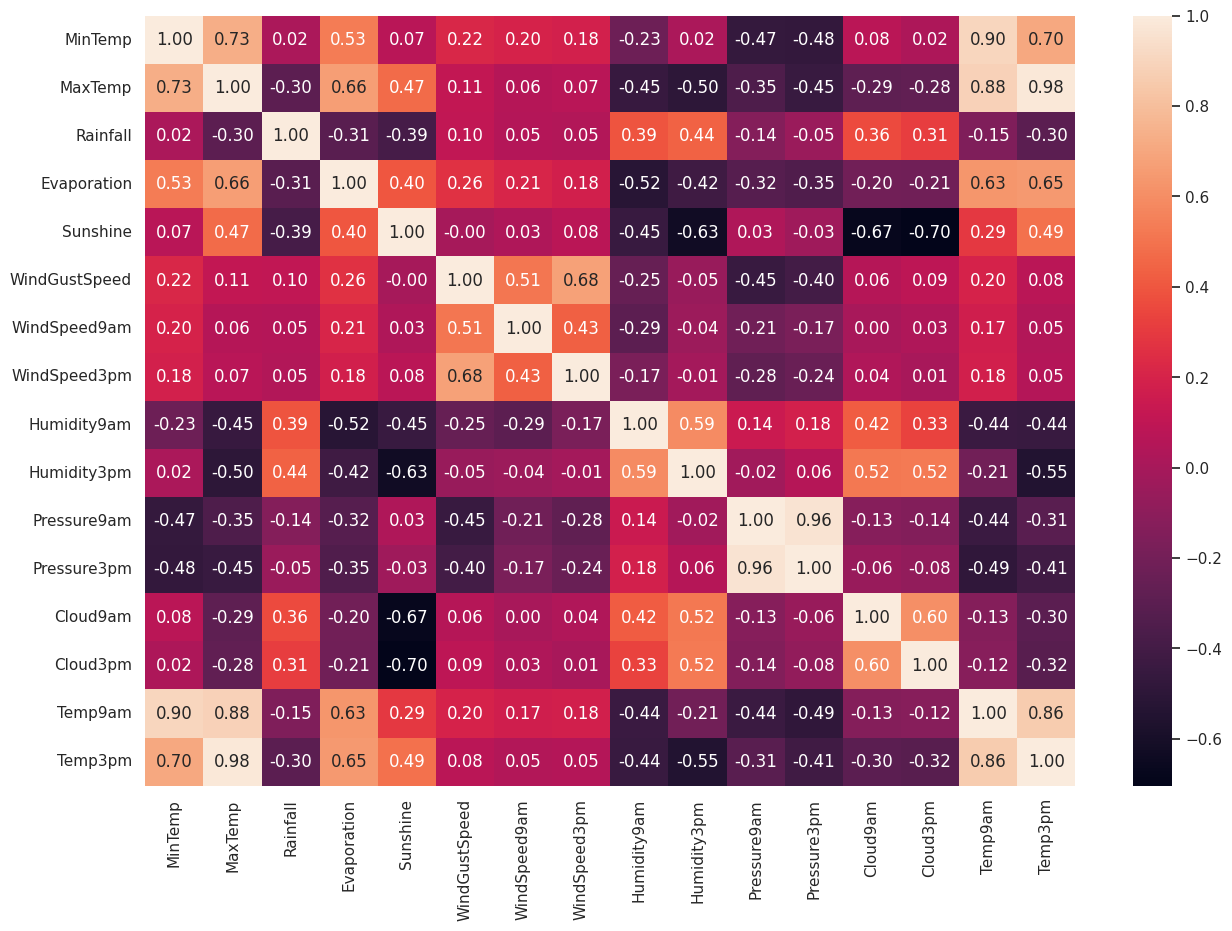

In [41]:
# correlation heatmap df
plt.figure(figsize=(15, 10))
correlation = df[numeric_columns].corr()
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.show()

let's check with code also

In [42]:
# Get column pairs with correlation > 0.5
high_corr_pairs = []
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > 0.5:
            high_corr_pairs.append((correlation.columns[i], correlation.columns[j], correlation.iloc[i, j]))

# Check if there are high correlation pairs
if high_corr_pairs:
    # Print column pairs with correlation > 0.5 and their correlation values
    for pair in high_corr_pairs:
        print(pair[0], "-", pair[1], "Correlation:", round(pair[2], 2))
else:
    print("No high correlation columns")

MinTemp - MaxTemp Correlation: 0.73
MinTemp - Evaporation Correlation: 0.53
MinTemp - Temp9am Correlation: 0.9
MinTemp - Temp3pm Correlation: 0.7
MaxTemp - Evaporation Correlation: 0.66
MaxTemp - Humidity3pm Correlation: -0.5
MaxTemp - Temp9am Correlation: 0.88
MaxTemp - Temp3pm Correlation: 0.98
Evaporation - Humidity9am Correlation: -0.52
Evaporation - Temp9am Correlation: 0.63
Evaporation - Temp3pm Correlation: 0.65
Sunshine - Humidity3pm Correlation: -0.63
Sunshine - Cloud9am Correlation: -0.67
Sunshine - Cloud3pm Correlation: -0.7
WindGustSpeed - WindSpeed9am Correlation: 0.51
WindGustSpeed - WindSpeed3pm Correlation: 0.68
Humidity9am - Humidity3pm Correlation: 0.59
Humidity3pm - Cloud9am Correlation: 0.52
Humidity3pm - Cloud3pm Correlation: 0.52
Humidity3pm - Temp3pm Correlation: -0.55
Pressure9am - Pressure3pm Correlation: 0.96
Cloud9am - Cloud3pm Correlation: 0.6
Temp9am - Temp3pm Correlation: 0.86


these variables have a very high correlation

## Bivariate Analysis

# Feature Processing & Engineering

## Drop Duplicates

In [43]:
data.shape

(144127, 23)

In [44]:
data.duplicated().sum()

0

let's have a closer look at the duplicates

In [45]:
dup = data.loc[data.duplicated(),:]
dup.head(22)

Empty DataFrame
Columns: [Location, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, Temp3pm, RainToday, RainTomorrow, Month]
Index: []

[0 rows x 23 columns]

these transactions look fraudulent, but they are not.

money was payed, but there is no trace of it in either sending or receiving accounts

so we'll leave them. Remember, we have to be careful as to avoid deleting useful training information.

these do not look like duplicates, since the amount is different for each record. So we'll ignore

## Impute Missing Values

In [46]:
data.isnull().sum()

Location             0
MinTemp           1295
MaxTemp           1077
Rainfall          3085
Evaporation      61982
Sunshine         68994
WindGustDir      10077
WindGustSpeed    10014
WindDir9am       10322
WindDir3pm        4008
WindSpeed9am      1552
WindSpeed3pm      2853
Humidity9am       2408
Humidity3pm       4281
Pressure9am      14528
Pressure3pm      14492
Cloud9am         55052
Cloud3pm         58507
Temp9am           1525
Temp3pm           3387
RainToday         3085
RainTomorrow      3084
Month                0
dtype: int64

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144127 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       144127 non-null  object 
 1   MinTemp        142832 non-null  float64
 2   MaxTemp        143050 non-null  float64
 3   Rainfall       141042 non-null  float64
 4   Evaporation    82145 non-null   float64
 5   Sunshine       75133 non-null   float64
 6   WindGustDir    134050 non-null  object 
 7   WindGustSpeed  134113 non-null  float64
 8   WindDir9am     133805 non-null  object 
 9   WindDir3pm     140119 non-null  object 
 10  WindSpeed9am   142575 non-null  float64
 11  WindSpeed3pm   141274 non-null  float64
 12  Humidity9am    141719 non-null  float64
 13  Humidity3pm    139846 non-null  float64
 14  Pressure9am    129599 non-null  float64
 15  Pressure3pm    129635 non-null  float64
 16  Cloud9am       89075 non-null   float64
 17  Cloud3pm       85620 non-null   fl

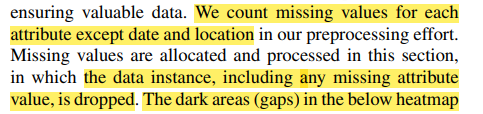

the missing values are too many to just drop them. I will replace them with the mean

In [48]:
# Drop the missing rows
data = data.dropna()

In [49]:
# # Replace missing values: if datatype is int or float, replace with mean; otherwise, replace with the most frequent value
# for column in data.columns:
#     if data[column].dtype in ['object']:
#         data[column].fillna(data[column].mode()[0], inplace=True)
#     else:
#         data[column].fillna(data[column].mean(), inplace=True)

Let us select variables that have a higher feature importance. This was decided after examining the feature importance of the decision tree model.

In [50]:
selected_cols = ['Sunshine', 'Humidity3pm', 'Pressure3pm', 'WindGustSpeed', 'Pressure9am', 'Temp9am', 'Humidity9am', 'MinTemp', 'WindSpeed9am', 'Evaporation', 'MaxTemp', 'Rainfall', 'Temp3pm', 'Month', 'WindSpeed3pm', 'Cloud3pm', 'Cloud9am', 'RainToday', 'RainTomorrow']

In [51]:
data = data[selected_cols]

# Features Encoding

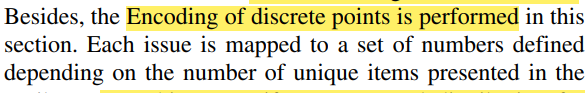

refering to the screenshot above, we'll encode the categoric variables here

In [52]:
categoric = [col for col in data.columns if data[col].dtype == 'object']
print("categoric_cols:", categoric)

categoric_cols: ['RainToday', 'RainTomorrow']


In [53]:
print("categoric_col", "-", "num_unique_values")
for col in categoric:
    print(col, "-", data[col].nunique())

categoric_col - num_unique_values
RainToday - 2
RainTomorrow - 2


ordinal encoding is suitable for variables that have a meaningful order, like small, medium, large. Directions like North, East, West, South do not have a specific order.

therefore, let us use one-hot encoder for them since it treats direction as independent, which fits the nature of these variables.

same applies for location

as for "RainToday" and "RainTomorrow", we'll encode "yes" as 1 and "no" as 0.

In [54]:
data['RainToday'] = data['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)
data['RainTomorrow'] = data['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

In [55]:
categoric.remove("RainTomorrow")
categoric.remove("RainToday")

In [56]:
# calling our encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first")
# setting output to DataFrame
encoder.set_output(transform="pandas")
# encoding our data
cat_encoded = encoder.fit_transform(data[categoric])

In [57]:
numeric = [col for col in data.columns if data[col].dtype in ['int32', 'int64', 'float64']]
print("numeric_cols:", numeric)

numeric_cols: ['Sunshine', 'Humidity3pm', 'Pressure3pm', 'WindGustSpeed', 'Pressure9am', 'Temp9am', 'Humidity9am', 'MinTemp', 'WindSpeed9am', 'Evaporation', 'MaxTemp', 'Rainfall', 'Temp3pm', 'Month', 'WindSpeed3pm', 'Cloud3pm', 'Cloud9am', 'RainToday', 'RainTomorrow']


In [58]:
data = pd.concat([cat_encoded, data[numeric]], axis=1)

In [59]:
data.head()

Sunshine  Humidity3pm  Pressure3pm  WindGustSpeed  Pressure9am  Temp9am  \
6049      12.3         13.0       1004.4       0.707140       1006.3     26.6   
6050      13.0          8.0       1012.1      -0.090452       1012.9     20.3   
6052      10.6         22.0       1009.2       0.589456       1012.3     28.7   
6053      12.2         22.0       1009.1      -0.601439       1012.7     29.1   
6054       8.4         15.0       1007.4      -0.253606       1010.7     33.6   

      Humidity9am  MinTemp  WindSpeed9am  Evaporation  MaxTemp  Rainfall  \
6049    -2.256745     17.9     -0.961429     1.615945     35.2 -5.199338   
6050    -1.824556     18.4      0.579039     1.994971     28.9 -5.199338   
6052    -1.371657     19.4      1.629992     1.394512     37.6 -5.199338   
6053    -1.562721     21.9     -0.961429     1.494155     38.4 -5.199338   
6054    -2.289988     24.2      0.380326     1.464186     41.0 -5.199338   

      Temp3pm  Month  WindSpeed3pm  Cloud3pm  Cloud9am  RainToday  \
6049     33.4      1      0.301855       5.0       2.0          0   
6050     27.0      1      0.096753       1.0       1.0          0   
6052     34.9      1     -0.338834       6.0       1.0          0   
6053     35.6      1     -1.710968       5.0       1.0          0   
6054     37.6      1     -0.574595       6.0       1.0          0   

      RainTomorrow  
6049             0  
6050             0  
6052             0  
6053             0  
6054             0

# Dataset Splitting

In [60]:
X = data.drop('RainTomorrow', axis=1)
y = data['RainTomorrow']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [62]:
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((44871, 18), (11218, 18), (44871,), (11218,))

# Features Scaling


In [63]:
# Scaler = StandardScaler().fit(X_train[numeric]).set_output(transform="pandas")

# X_numScaled_train = Scaler.transform(X_train[numeric])
# X_numScaled_test = Scaler.transform(X_test[numeric])

In [64]:
# X_train = pd.concat([X_numScaled_train, X_catEncoded_train], axis=1)
# X_test = pd.concat([X_numScaled_test, X_catEncoded_test], axis=1)

## Data Imbalance Check

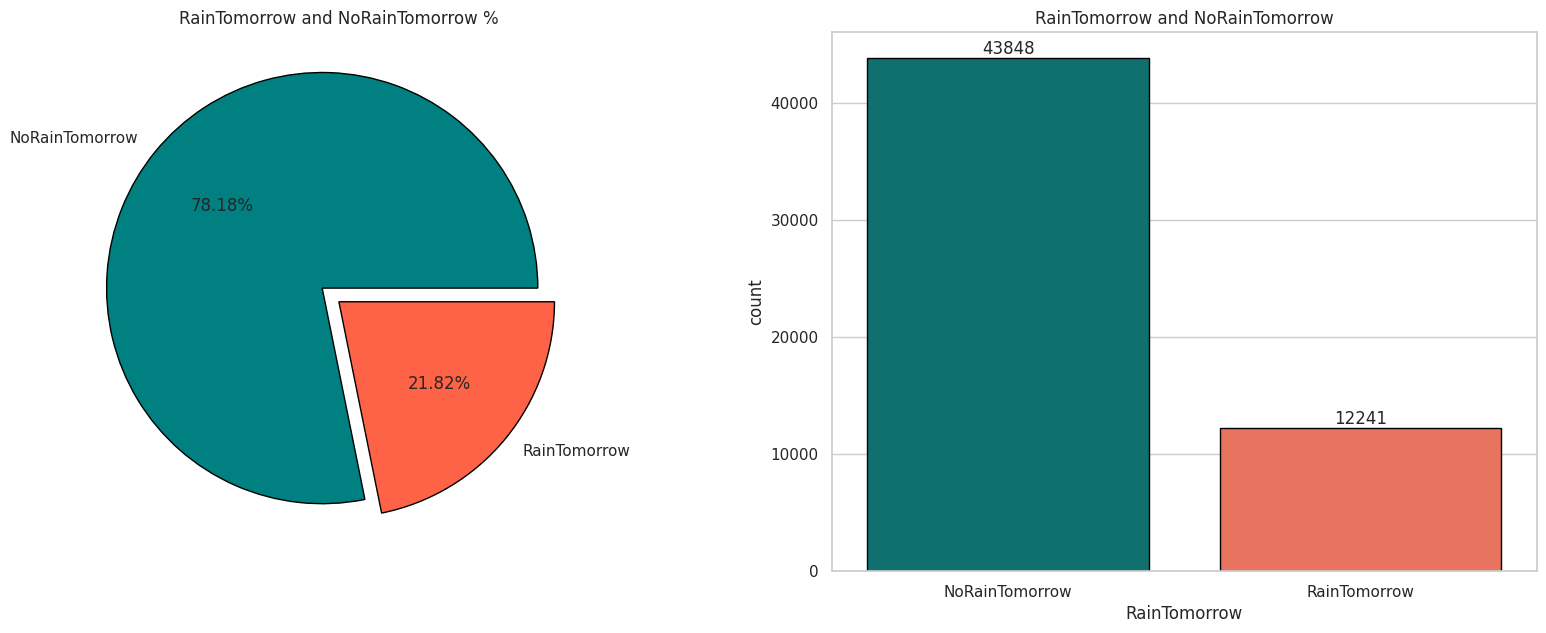

In [65]:
#Defining colors for the plots
palette = ['#008080','#FF6347', '#E50000', '#D2691E']
palette2 = ['#FF6347', '#008080', '#E50000', '#D2691E']

l1 = list(data['RainTomorrow'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['NoRainTomorrow','RainTomorrow'],
        autopct = '%1.2f%%',
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('RainTomorrow and NoRainTomorrow %');

plt.subplot(1,2,2)
ax = sns.countplot(data = data,
                   x='RainTomorrow',
                   palette = palette,
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['NoRainTomorrow','RainTomorrow'])

plt.title('RainTomorrow and NoRainTomorrow')
plt.show()


Dataset is imbalanced. Fraudulent cases are only 0.13% of our data.

This means that a blind guess (on "No Fraud") would give us accuracy of 99%

Therefore, we can't use Accuracy Score to choose our model

what to do to solve this issue:

1. We could use stratified splitting during train-test split (split the dataset in a way that preserves the same proportions of examples in each class.)
2. We could be extra careful when dealing with outliers (we can delete meaningull information).
3. Resampling Techniques — Oversample minority class or Undersample majority class.

the researchers did not use any method to balance the dataset. They just left it like that which I completely disagree with. What is the point of even checking if you still plan on leaving it imbalanced?

In [66]:
#Oversampling the minority class (RainTomorrow)
ros = RandomOverSampler(random_state=0)
X_new,y_new= ros.fit_resample(X_train, y_train)

print("After Random Over Sampling Of Minor Class Total Samples are :", len(y_new))
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))

After Random Over Sampling Of Minor Class Total Samples are : 70212
Original dataset shape Counter({0: 43848, 1: 12241})
Resampled dataset shape Counter({1: 35106, 0: 35106})


In [67]:
X_train, y_train = X_new,y_new

Now our data is balanced, 1 reprents RinTomorrow while 0 represents noRainTomorrow

# Machine Learning Modeling


## 1.  Logistic Regression

### Create the Model

In [68]:
model= LogisticRegression()

### Train the Model

In [69]:
model=model.fit(X_train, y_train)


###  Predict on the test dataset

In [70]:
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]


### Model Evaluation

In [71]:
r_lgt= recall_score(y_test, pred)
print("recall_score : ", r_lgt)

p_lgt= precision_score(y_test, pred)
print("precision_score :",p_lgt)

f1_lgt= f1_score(y_test, pred)
print("f1_score :", f1_lgt)

f2_lgt = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score :", f2_lgt)

A_lgt= accuracy_score(pred, y_test)
print("accuracy_score :",A_lgt)

acu_lgt = roc_auc_score(pred, y_test)
print("ROC_AUC Score:",acu_lgt)


recall_score :  0.7734248788368336
precision_score : 0.5134048257372654
f1_score : 0.617144698678698
f2_score : 0.7022883966554203
accuracy_score : 0.7881975396683901
ROC_AUC Score: 0.7192424769711968


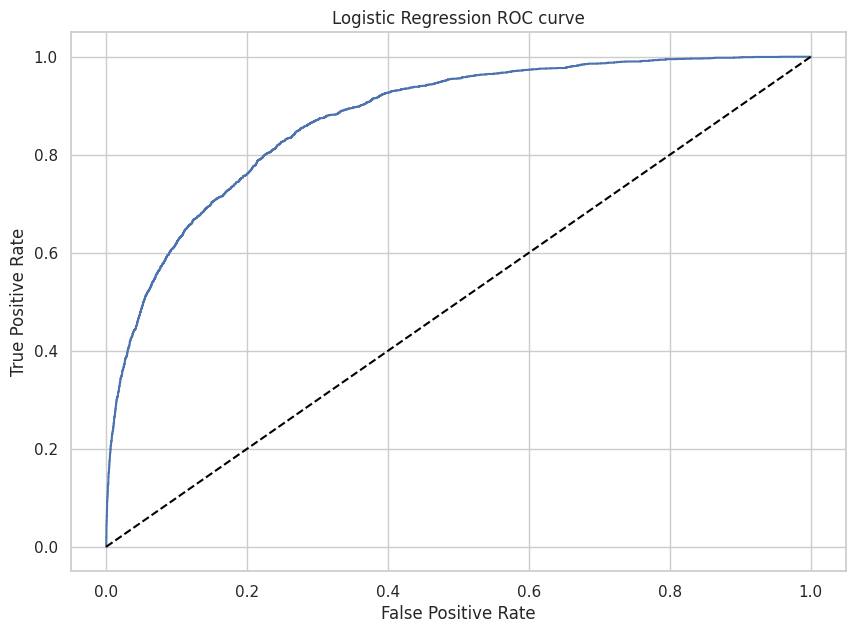

In [72]:
# plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Logistic Regression ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

##  6. DecisionTreeClassifier

### Create the Model

In [73]:
dtmodel = DecisionTreeClassifier()

### Train the Model

In [74]:
dtmodel = dtmodel.fit(X_train, y_train)

### Predict on the test dataset

In [75]:
dt_pred = dtmodel.predict(X_test)
dt_prob = dtmodel.predict_proba(X_test)[:,1]

### Model Evaluation

In [76]:
r_dt= recall_score(y_test, dt_pred)
print("recall_score : ", r_dt)

p_dt= precision_score(y_test, dt_pred)
print("precision_score :",p_dt)

f1_dt= f1_score(y_test, dt_pred)
print("f1_score :", f1_dt)

f2_dt = fbeta_score(y_test, dt_pred, beta=2, average='binary')
print("f2_score :", f2_dt)


A_dt= accuracy_score( y_test, dt_pred)
print("accuracy_score :", A_dt)

acu_dt = roc_auc_score(dt_pred, y_test)
print("ROC_AUC Score:",acu_dt)

recall_score :  0.5351373182552503
precision_score : 0.5392755392755393
f1_score : 0.5371984593553618
f2_score : 0.5359598737966184
accuracy_score : 0.7964877874844001
ROC_AUC Score: 0.7039489213327816


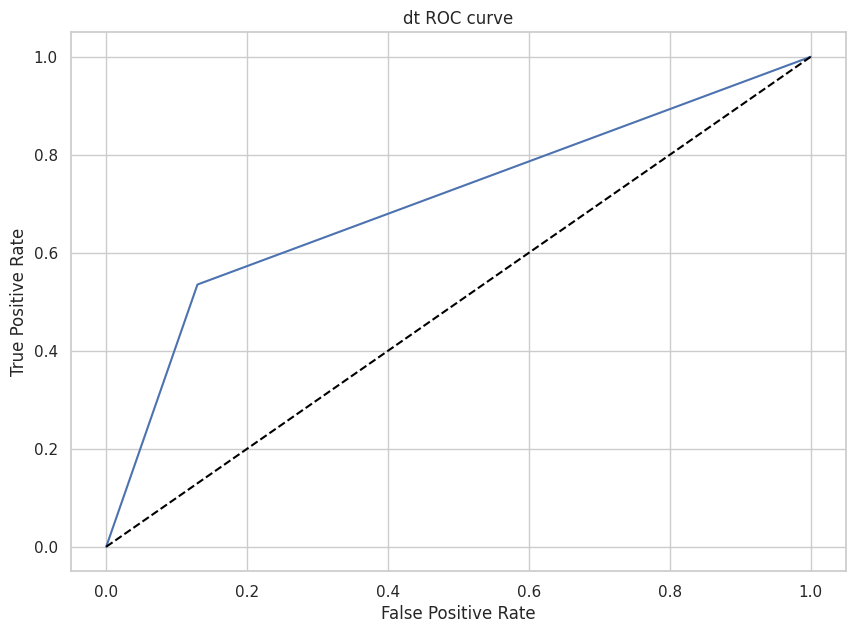

In [77]:
#  plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, dt_prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('dt ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

## RandomForestClassifier

In [78]:
# Define and fit the Random Forest model
model = RandomForestClassifier()
model = model.fit(X_train, y_train)

# Make predictions
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:, 1]

# Calculate recall
r_rf = recall_score(y_test, pred)
print("recall_score:", r_rf)

# Calculate precision
p_rf = precision_score(y_test, pred)
print("precision_score:", p_rf)

# Calculate F1 score
f1_rf = f1_score(y_test, pred)
print("f1_score:", f1_rf)

# Calculate F2 score
f2_rf = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score:", f2_rf)

# Calculate accuracy
A_rf = accuracy_score(y_test, pred)
print("accuracy_score:", A_rf)

# Calculate ROC AUC score
acu_rf = roc_auc_score(y_test, prob)
print("ROC_AUC Score:", acu_rf)

recall_score: 0.6130856219709209
precision_score: 0.7083527764815679
f1_score: 0.6572851266507902
f2_score: 0.6300323732049473
accuracy_score: 0.8588875022285613
ROC_AUC Score: 0.8934154291632064


## Support Vector Machine (SVM)

In [79]:
# from sklearn.svm import SVC

# # Define and fit the SVM model with probability estimates enabled
# model = SVC(probability=True)
# model = model.fit(X_train, y_train)

# # Make predictions
# pred = model.predict(X_test)
# prob = model.predict_proba(X_test)[:, 1]

# # Calculate recall
# r_svm = recall_score(y_test, pred)
r_svm = 0
# print("recall_score:", r_svm)

# # Calculate precision
# p_svm = precision_score(y_test, pred)
p_svm = 0
# print("precision_score:", p_svm)

# # Calculate F1 score
# f1_svm = f1_score(y_test, pred)
f1_svm = 0
# print("f1_score:", f1_svm)

# # Calculate F2 score
# f2_svm = fbeta_score(y_test, pred, beta=2, average='binary')
f2_svm = 0
# print("f2_score:", f2_svm)

# # Calculate accuracy
# A_svm = accuracy_score(y_test, pred)
A_svm = 0
# print("accuracy_score:", A_svm)

# # Calculate ROC AUC score
# acu_svm = roc_auc_score(y_test, prob)
acu_svm = 0
# print("ROC_AUC Score:", acu_svm)

## Artificial Neural Network (ANN)

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score, roc_auc_score

# Define the ANN ann_model
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))

# Compile the ann_model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the ann_model
ann_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Make predictions
pred = (ann_model.predict(X_test) > 0.5).astype("int32").flatten()
prob = ann_model.predict(X_test).flatten()

# Calculate recall
r_ann = recall_score(y_test, pred)
print("recall_score:", r_ann)

# Calculate precision
p_ann = precision_score(y_test, pred)
print("precision_score:", p_ann)

# Calculate F1 score
f1_ann = f1_score(y_test, pred)
print("f1_score:", f1_ann)

# Calculate F2 score
f2_ann = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score:", f2_ann)

# Calculate accuracy
A_ann = accuracy_score(y_test, pred)
print("accuracy_score:", A_ann)

# Calculate ROC AUC score
acu_ann = roc_auc_score(y_test, prob)
print("ROC_AUC Score:", acu_ann)

Epoch 1/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6767 - loss: 1.6467
Epoch 2/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7234 - loss: 0.9408
Epoch 3/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7300 - loss: 0.8081
Epoch 4/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7395 - loss: 0.6995
Epoch 5/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7465 - loss: 0.6430
Epoch 6/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7476 - loss: 0.5996
Epoch 7/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7538 - loss: 0.5676
Epoch 8/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7556 - loss: 0.5472
Epoch 9/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7530 - loss: 0.5442
Epoch 10/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7689 - loss: 0.4918
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
recall_score: 0.8222940226171244
prec

## Naive Bayes

In [81]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score, roc_auc_score

# Define and fit the Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:, 1]

# Calculate recall
r_nb = recall_score(y_test, pred)
print("recall_score:", r_nb)

# Calculate precision
p_nb = precision_score(y_test, pred)
print("precision_score:", p_nb)

# Calculate F1 score
f1_nb = f1_score(y_test, pred)
print("f1_score:", f1_nb)

# Calculate F2 score
f2_nb = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score:", f2_nb)

# Calculate accuracy
A_nb = accuracy_score(y_test, pred)
print("accuracy_score:", A_nb)

# Calculate ROC AUC score
acu_nb = roc_auc_score(y_test, prob)
print("ROC_AUC Score:", acu_nb)


recall_score: 0.7701938610662359
precision_score: 0.46466861598440545
f1_score: 0.5796352583586626
f2_score: 0.680682467161622
accuracy_score: 0.7534319843109288
ROC_AUC Score: 0.8445472786750979


## LSTM

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score, roc_auc_score
import numpy as np

# Reshape data for LSTM input (samples, timesteps, features)
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

# Make predictions
pred = (model.predict(X_test_lstm) > 0.5).astype("int32").flatten()
prob = model.predict(X_test_lstm).flatten()

# Calculate recall
r_lstm = recall_score(y_test, pred)
print("recall_score:", r_lstm)

# Calculate precision
p_lstm = precision_score(y_test, pred)
print("precision_score:", p_lstm)

# Calculate F1 score
f1_lstm = f1_score(y_test, pred)
print("f1_score:", f1_lstm)

# Calculate F2 score
f2_lstm = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score:", f2_lstm)

# Calculate accuracy
A_lstm = accuracy_score(y_test, pred)
print("accuracy_score:", A_lstm)

# Calculate ROC AUC score
acu_lstm = roc_auc_score(y_test, prob)
print("ROC_AUC Score:", acu_lstm)


Epoch 1/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7215 - loss: 0.8209
Epoch 2/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7764 - loss: 0.4795
Epoch 3/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7773 - loss: 0.4732
Epoch 4/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7776 - loss: 0.4741
Epoch 5/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7826 - loss: 0.4629
Epoch 6/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7758 - loss: 0.4750
Epoch 7/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7754 - loss: 0.4779
Epoch 8/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7810 - loss: 0.4626
Epoch 9/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7821 - loss: 0.4636
Epoch 10/10
2195/2195 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7811 - loss: 0.4600
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
recall_score: 0.7176898222940227


# Models comparison

since missing rainfall events is more costly, false negatives are more important.

false negatives occur when the model predicts no rain, but rain actually falls. Unexpected rainfall on your wedding day is problematic, so we will evaluate our model based on metrics that prioritize false negatives.

f2 score and recall both emphasize false negatives, so this is the perfect choice. We can't use accuracy as a metric because our dataset is imbalanced, and we had to resample it.

meaning all that yapping they did in the research paper about other metrics, I really think they either copied it from somewhere, or the wrote it there to fill white space, and meet the required word count for the paper.

### before feature selection

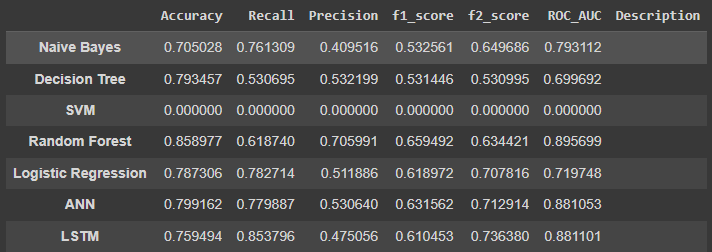

### after feature selection

In [83]:
# List of models for comparison
compare_models = ['Naive Bayes', 'Decision Tree', 'SVM', 'Random Forest', 'Logistic Regression', 'ANN', 'LSTM']

# Dictionary of results
data_compare = {
    'Accuracy': [A_nb, A_dt, A_svm, A_rf, A_lgt, A_ann, A_lstm],
    'Recall': [r_nb, r_dt, r_svm, r_rf, r_lgt, r_ann, r_lstm],
    'Precision': [p_nb, p_dt, p_svm, p_rf, p_lgt, p_ann, p_lstm],
    'f1_score': [f1_nb, f1_dt, f1_svm, f1_rf, f1_lgt, f1_ann, f1_lstm],
    'f2_score': [f2_nb, f2_dt, f2_svm, f2_rf, f2_lgt, f2_ann, f2_lstm],
    'ROC_AUC': [acu_nb, acu_dt, acu_svm, acu_rf, acu_lgt, acu_ann, acu_lstm],
    'Description': ['', '', '', '', '', '', '']
}

# Create DataFrame with the comparison results
result = pd.DataFrame(data=data_compare, index=compare_models)
result


Accuracy    Recall  Precision  f1_score  f2_score  \
Naive Bayes          0.753432  0.770194   0.464669  0.579635  0.680682   
Decision Tree        0.796488  0.535137   0.539276  0.537198  0.535960   
SVM                  0.000000  0.000000   0.000000  0.000000  0.000000   
Random Forest        0.858888  0.613086   0.708353  0.657285  0.630032   
Logistic Regression  0.788198  0.773425   0.513405  0.617145  0.702288   
ANN                  0.765912  0.822294   0.482236  0.607943  0.720657   
LSTM                 0.817258  0.717690   0.568095  0.634190  0.681783   

                      ROC_AUC Description  
Naive Bayes          0.844547              
Decision Tree        0.703949              
SVM                  0.000000              
Random Forest        0.893415              
Logistic Regression  0.719242              
ANN                  0.875240              
LSTM                 0.875552

Recall measures the ability to identify if rain will actually fall (minimizing false negatives), while the f2_score places more emphasis on recall compared to precision.


Based on the above metrics, **LSTM is the best model** for this rainfall detection project as it has the highest recall (0.8) and a high f2_score (0.7), indicating it is effective in detecting rainfall while minimizing false negatives (minimizing cases where it predicted no rain and rain still fell).

In the context of rainfall prediction, ROC_AUC is important because it gives a holistic view of the model's performance across all classification thresholds.

Based on the ROC_AUC values and previously discussed metrics (recall and f2_score), decisionTree Classifier stands out as the best model for this rainfall prediction project with the 2nd highest ROC_AUC (0.88).

# k-Fold cross validation

## ANN

In [85]:
# Define the custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# Define the ANN model-building function
def build_ann():
    ann_model = Sequential()
    ann_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    ann_model.add(Dense(32, activation='relu'))
    ann_model.add(Dense(1, activation='sigmoid'))
    ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return ann_model

# Custom function to handle cross-validation for the Keras model
def cross_val_f2_score(model_builder, X, y, cv, scorer):
    scores = []
    for train_idx, val_idx in cv.split(X):
        # Build and train the model
        model = model_builder()
        model.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)

        # Generate predictions and evaluate F2 score
        predictions = (model.predict(X[val_idx]) > 0.5).astype(int)
        score = scorer._score_func(y[val_idx], predictions, beta=2)
        scores.append(score)
    return scores

# Set up 5-fold cross-validation
ann_fold = KFold(n_splits=5, shuffle=True)

# Calculate F2 scores for each fold
scores = cross_val_f2_score(build_ann, X_train.values, y_train.values, cv=ann_fold, scorer=f2_scorer)
ann_cv_score = np.mean(scores)
ann_cv_stdev = stdev(scores)

print('Cross Validation F2 scores are: {}'.format(scores))
print('Average Cross Validation F2 score: ', ann_cv_score)
print('Cross Validation F2 standard deviation: ', ann_cv_stdev)

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Cross Validation F2 scores are: [0.6407626402799566, 0.848040848040848, 0.7888474770642202, 0.6075608936157207, 0.8410097066021393]
Average Cross Validation F2 score:  0.7452443131205769
Cross Validation F2 standard deviation:  0.11348184662349509


after evaluation with KFold cross validation,

our best model maintains its high performance

# Feature Importance

# DecisionTreeClassifier

before feature selection:

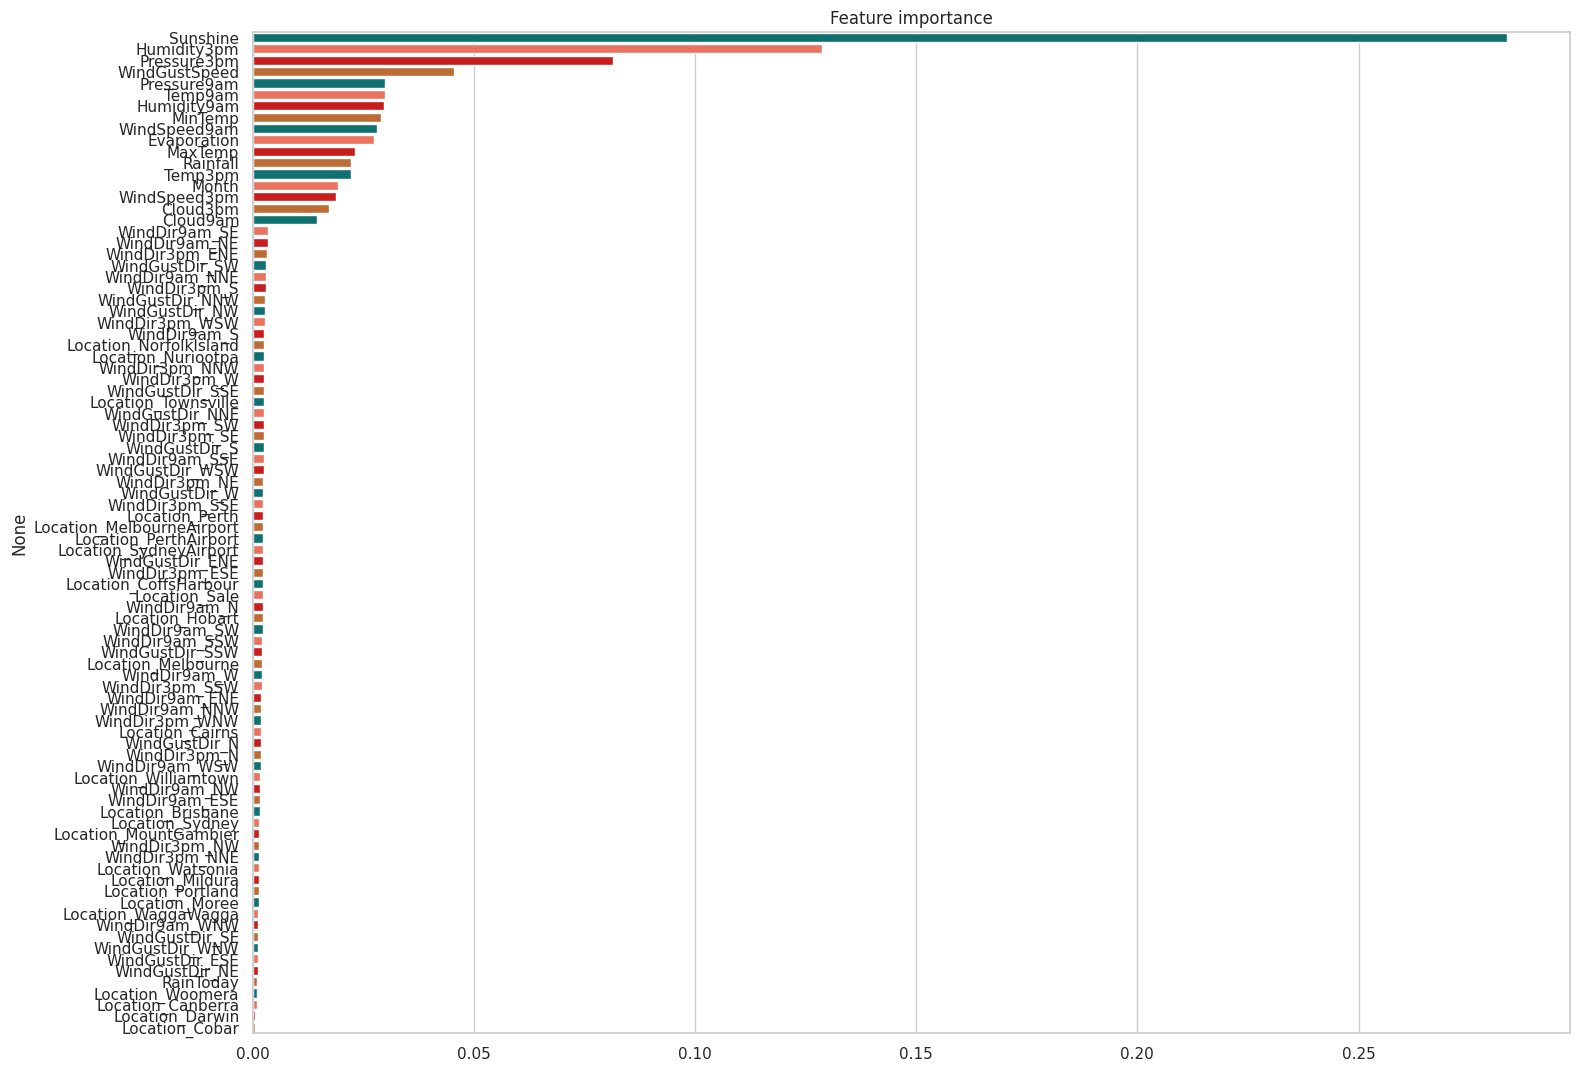

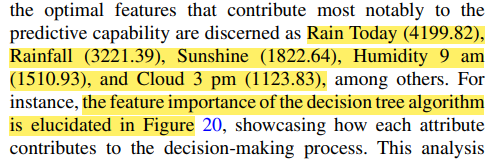

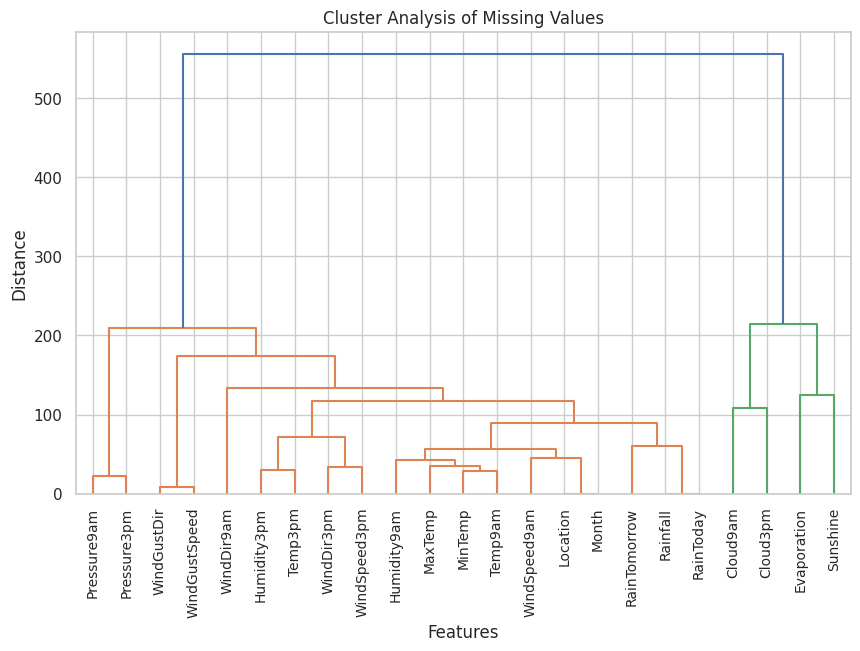

after feature selection:

In [ ]:
fimp = pd.Series(data=dtmodel.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')


#### for exporting the ml assets (scaler, model, encoder) for deployment

In [ ]:
# with open('model.pkl', 'wb') as f:
#     pickle.dump(dt_tuned, f)

# Using Confusion Matrix For Predictions

# ANN

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
y_pred_dt = ann_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_dt, labels=dtmodel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=dtmodel.classes_)
disp.plot(ax=ax)
plt.show()

Based on confusion matrix:

1. There are 438 transactions predicted to have fraud when they actually don't, this can be corrected with investigation within the company
2. There are 0 transactions predicted to not have fraud when they actually do, this is more important